## 피마 인디언 당뇨병 예측

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_recall_curve

In [197]:
df = pd.read_csv('../00_data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#### Feature 설명
- Pregnancies: 임신 횟수
- Glucose: 포도당 부하 검사 수치
- BloodPressure: 혈압
- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값
- Insulin: 혈청 인슐린
- BMI: 체질량 지수(체중/키)
- DiabetesPedigreeFunction: 당뇨 내력 가중치 값
- Age: 나이
- Outcome: 클래스 결정 값

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [199]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 결측치 확인 및 처리

In [200]:
len(df[df['Glucose'] == 0])

5

In [201]:
len(df[df['BloodPressure'] == 0])

35

In [202]:
len(df[df['SkinThickness'] == 0])

227

In [203]:
len(df[df['Insulin'] == 0])

374

In [204]:
len(df[df['BMI'] == 0])

11

In [205]:
# 결측치인 0이 들어가있는 데이터를 평균값으로 대체
df.replace({'Glucose': 0}, {'Glucose': round(df['Glucose'].mean(), 2)}, inplace=True)
df.replace({'BloodPressure': 0}, {'BloodPressure': round(df['BloodPressure'].mean(), 2)}, inplace=True)
df.replace({'SkinThickness': 0}, {'SkinThickness': round(df['SkinThickness'].mean(), 2)}, inplace=True)
df.replace({'Insulin': 0}, {'Insulin': round(df['Insulin'].mean(), 2)}, inplace=True)
df.replace({'BMI': 0}, {'BMI': round(df['BMI'].mean(), 2)}, inplace=True)

In [206]:
print(len(df[df['Glucose'] == 0]), len(df[df['BloodPressure'] == 0]), len(df[df['SkinThickness'] == 0]), len(df[df['Insulin'] == 0]), len(df[df['BMI'] == 0]))

0 0 0 0 0


### Feature Scaling

In [207]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### train/test 데이터 세트 분리

In [208]:
# 'Outcome' 속성을 y로 나머지 feature를 X로 만듦
X_train, X_test, y_train, y_test=train_test_split(
    X_scaled, y, test_size=0.2, random_state = 156, stratify=y
)

### 로지스틱 회귀로 학습 / 예측 / 평가

In [209]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 스코어: {f1:.4f}, ROC AUC 스코어: {roc_auc:.4f}')

In [210]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행.
    plt.figure(figsize=(10,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [211]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1 스코어: 0.6804, ROC AUC 스코어: 0.7556


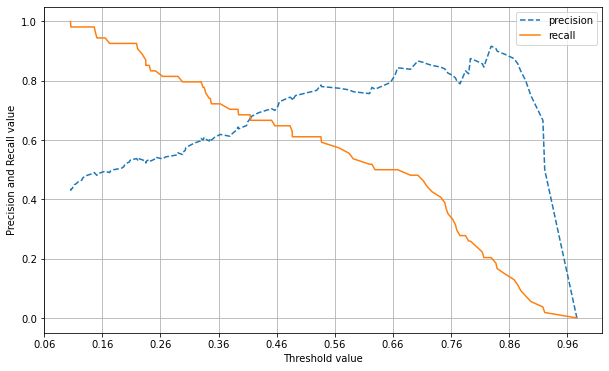

In [212]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

### 정밀도(Precision) / 재현율(Recall) Trade-off

In [213]:
pred_proba = lr_clf.predict_proba(X_test)
pred_proba[:10, :]

array([[0.96439639, 0.03560361],
       [0.79931428, 0.20068572],
       [0.8423311 , 0.1576689 ],
       [0.43341289, 0.56658711],
       [0.5856663 , 0.4143337 ],
       [0.24552929, 0.75447071],
       [0.16083284, 0.83916716],
       [0.8493489 , 0.1506511 ],
       [0.80710533, 0.19289467],
       [0.89337083, 0.10662917]])

In [214]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)
        print('\n')

In [215]:
thresholds = [0.36, 0.39, 0.42, 0.45, 0.48, 0.50, 0.53, 0.56, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1 스코어: 0.6667, ROC AUC 스코어: 0.7411


임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1 스코어: 0.6667, ROC AUC 스코어: 0.7419


임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1 스코어: 0.6792, ROC AUC 스코어: 0.7533


임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1 스코어: 0.6857, ROC AUC 스코어: 0.7583


임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1 스코어: 0.6931, ROC AUC 스코어: 0.7641


임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1 스코어: 0.6804, ROC AUC 스코어: 0.7556


임곗값: 0.53
오차 행렬
[[91  9]
 [21 33]]
정확도: 0.8052, 정밀도: 0.7857, 재현율: 0.6111, F1 스코어: 0.6875, ROC AUC 스코어: 0.7606


임곗값: 0.56
오차 행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741, F1 스코어: 0.6596, ROC AUC 스코어: 0.7420


임곗값: 0.6
오차 행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185, F1 스코어: 0.6154, ROC AUC 스코어: 0.7

#### 임곗값이 0.48일 때 가장 높은 ROC AUC 스코어를 갖는다.